# Day 2 — Vector Math: From BoW → TF‑IDF → Embeddings → RAG → RBAC

This notebook is a guided walk from **sparse text vectors** to **dense embeddings**, then into **vector search** (the core of vector stores), and finally into **RAG** and **RBAC filtering**.

## What you’ll learn

- How **Bag‑of‑Words** and **TF‑IDF** represent text (and why they’re brittle)
- What an **embedding vector** is, and how to inspect it
- How **similarity** works (Euclidean vs cosine) and why cosine is the default
- Vector space operations (classic: `king - man + woman`)
- What a **vector store** is (top‑K retrieval fast), compared to classic indexing/hashing
- How vector retrieval becomes **RAG**, and how RBAC constrains visibility


In [ ]:
# -- SETUP --

import json
import os
import glob
import time
import re
from dataclasses import dataclass
from functools import lru_cache

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

import torch
from sentence_transformers import SentenceTransformer

px.defaults.template = "plotly_white"

np.set_printoptions(suppress=True, linewidth=140)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

ST_EMBED_MODEL_ID = os.environ.get("ST_EMBED_MODEL_ID", "sentence-transformers/all-MiniLM-L6-v2")
GPT2_MODEL_ID = os.environ.get("GPT2_MODEL_ID", "gpt2")
GLOVE_MODEL_ID = os.environ.get("GLOVE_MODEL_ID", "glove-wiki-gigaword-50")

print("device:", DEVICE)
print("ST_EMBED_MODEL_ID:", ST_EMBED_MODEL_ID)
print("GPT2_MODEL_ID:", GPT2_MODEL_ID)
print("GLOVE_MODEL_ID:", GLOVE_MODEL_ID)


def l2norm(v: np.ndarray) -> float:
    v = np.asarray(v, dtype=np.float32)
    return float(np.linalg.norm(v) + 1e-12)


def cosine(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    return float((a @ b) / ((np.linalg.norm(a) + 1e-12) * (np.linalg.norm(b) + 1e-12)))


def show_vector(v: np.ndarray, *, full: bool = True, max_items: int = 24) -> str:
    """Pretty-print a vector. Set full=True to show everything."""
    v = np.asarray(v, dtype=np.float32).reshape(-1)
    if full or v.size <= max_items:
        return np.array2string(v, precision=4, separator=", ")
    head = np.array2string(v[:max_items], precision=4, separator=", ")
    return head[:-1] + f", ... ({v.size - max_items} more)]"


@lru_cache(maxsize=2)
def get_sentence_embedder() -> SentenceTransformer:
    return SentenceTransformer(ST_EMBED_MODEL_ID, device=DEVICE)


print("✅ Setup complete.")


✅ Cockpit Initialized.


## A) Sparse representations: Bag‑of‑Words and TF‑IDF

First, we’ll represent text as **sparse vectors**.

- **Bag‑of‑Words (BoW)**: counts words.
- **TF‑IDF**: counts words but downweights very common ones.

These methods are simple and fast, but they struggle with synonyms and “meaning”.



In [ ]:
# Toy corpus (sparse vectors)

docs = [
    "A cat sits on the mat.",
    "A dog plays fetch in the park.",
    "The loan APR depends on interest rate and fees.",
    "Mortgage underwriting uses credit score and debt-to-income ratio.",
    "GPU latency increases when memory is fragmented.",
    "Kubernetes incident response runbooks reduce mean time to recovery.",
]
query = "APR interest rate for a loan"

print("query:", query)

# BoW
bow = CountVectorizer(lowercase=True, stop_words="english")
X_bow = bow.fit_transform(docs)
q_bow = bow.transform([query])

# TF-IDF
tfidf = TfidfVectorizer(lowercase=True, stop_words="english")
X_tfidf = tfidf.fit_transform(docs)
q_tfidf = tfidf.transform([query])

print("BoW vocab size:", len(bow.vocabulary_))
print("TF-IDF vocab size:", len(tfidf.vocabulary_))

# Similarity (dot-product in sparse space)
# NOTE: TF-IDF vectors are not normalized by default; dot product is still a reasonable proxy here.
sim_bow = (X_bow @ q_bow.T).toarray().reshape(-1)
sim_tfidf = (X_tfidf @ q_tfidf.T).toarray().reshape(-1)

out = pd.DataFrame(
    {
        "doc": docs,
        "bow_dot": sim_bow,
        "tfidf_dot": sim_tfidf,
    }
).sort_values("tfidf_dot", ascending=False)

display(out)

# Inspect the sparse TF-IDF dimensions used by the query
q_terms = np.array(tfidf.get_feature_names_out())
q_nz = q_tfidf.nonzero()[1]
print("\nTF-IDF query nonzero terms:")
print(q_terms[q_nz])



In [ ]:
# Inspect the *sparse* TF-IDF vector for the query (interpretability)

terms = np.array(tfidf.get_feature_names_out())
q_vec = q_tfidf.toarray().reshape(-1)
idx = np.where(q_vec != 0)[0]

df_q = pd.DataFrame({"term": terms[idx], "tfidf": q_vec[idx]}).sort_values("tfidf", ascending=False)
display(df_q)

print("Takeaway: sparse vectors are interpretable (you can see the exact words), but they don’t capture synonyms/meaning well.")



## B) Dense embeddings: vectors that carry meaning

Dense embeddings map text to a fixed-size vector (e.g. 384 floats). You can think of it as a point in a high-dimensional space.

Key idea:
- Similar meaning → vectors close together.
- Similarity is usually computed with **cosine similarity**.



In [ ]:
# Interactive embedding inspector: type a word/sentence and see the full vector

EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
embedder_small = SentenceTransformer(EMBED_MODEL_ID, device=DEVICE)

w_text = widgets.Text(value="GPU latency", description="Text:", layout=widgets.Layout(width="700px"))
w_full = widgets.Checkbox(value=False, description="Show full vector")
run_btn = widgets.Button(description="Embed", button_style="primary")

out = widgets.Output()


def _embed_one(s: str) -> np.ndarray:
    v = embedder_small.encode([s], normalize_embeddings=False, convert_to_numpy=True, show_progress_bar=False)[0]
    return v.astype(np.float32)


def _render(_=None):
    s = (w_text.value or "").strip()
    if not s:
        return
    with out:
        clear_output(wait=True)
        v = _embed_one(s)
        n = int(v.shape[0])
        v_norm = v / (np.linalg.norm(v) + 1e-12)

        print("model:", EMBED_MODEL_ID)
        print("text:", repr(s))
        print("dim:", n)
        print("L2 norm:", f"{float(np.linalg.norm(v)):.4f}")

        head_n = min(24, n)
        df_head = pd.DataFrame({"dim": np.arange(head_n, dtype=int), "value": v[:head_n]})
        display(df_head)
        px.line(df_head, x="dim", y="value", title="Embedding preview (first dims)").show()

        if w_full.value:
            df_full = pd.DataFrame({"dim": np.arange(n, dtype=int), "value": v})
            display(df_full)

        # Compare against a couple references
        refs = ["GPU performance", "interest rate APR", "Kubernetes crash loop"]
        E = embedder_small.encode(refs, normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False).astype(np.float32)
        sims = E @ v_norm.astype(np.float32)

        print("\ncosine similarities (normalized embeddings):")
        for r, s0 in sorted(zip(refs, sims.tolist()), key=lambda x: -x[1]):
            print(f"  {float(s0):0.3f} | {r}")


run_btn.on_click(_render)
w_text.on_submit(_render)
w_full.observe(_render, names="value")

display(widgets.VBox([widgets.HBox([w_text, run_btn, w_full]), out]))
_render()



In [ ]:
# Compare retrieval: TF-IDF vs embeddings (toy corpus)

def cosine_topk(vectors: np.ndarray, q: np.ndarray, k: int = 5):
    vectors = vectors.astype(np.float32)
    q = q.astype(np.float32)
    vectors = vectors / (np.linalg.norm(vectors, axis=1, keepdims=True) + 1e-12)
    q = q / (np.linalg.norm(q) + 1e-12)
    sims = vectors @ q
    k = min(int(k), len(sims))
    idx = np.argpartition(-sims, k - 1)[:k]
    idx = idx[np.argsort(-sims[idx])]
    return idx.tolist(), sims[idx].tolist()

E_docs = embedder_small.encode(docs, normalize_embeddings=False, convert_to_numpy=True, show_progress_bar=False).astype(np.float32)
q_emb = embedder_small.encode([query], normalize_embeddings=False, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)

idx, sims = cosine_topk(E_docs, q_emb, k=5)

rows = []
for i, s in zip(idx, sims):
    rows.append({"rank": len(rows) + 1, "cosine": float(s), "doc": docs[int(i)]})

display(pd.DataFrame(rows))

print("\nNote: embeddings can match conceptually even when exact words differ; TF-IDF mostly rewards literal overlap.")



## C) Vector space operations: add/subtract (king − man + woman)

Now that we have vectors, we can do *math in meaning space*.

The classic demo is:

- `king - man + woman ≈ queen`

This works best with **word embedding** models trained explicitly for word-level geometry (we’ll use a small GloVe model).



In [ ]:
# Word vectors for analogies (GloVe)

import gensim.downloader as api

print(f"Loading gensim vectors: {GLOVE_MODEL_ID} (cached after first download)")
wv = api.load(GLOVE_MODEL_ID)

# Analogy arithmetic
#   king - man + woman ≈ queen
v_king = wv["king"]
v_man = wv["man"]
v_woman = wv["woman"]
v_combo = v_king - v_man + v_woman

print("Top results for king - man + woman:")
for word, score in wv.similar_by_vector(v_combo, topn=10):
    print(f"  {word:>12s}  sim={score:0.3f}")

# Visualize in 2D (PCA) and draw the arithmetic as arrows
words = ["king", "queen", "man", "woman", "prince", "princess", "royal"]
vecs = {w: wv[w] for w in words if w in wv}
vecs["king - man + woman"] = v_combo

labels = list(vecs.keys())
X = np.stack([vecs[k] for k in labels]).astype(np.float32)
Z = PCA(n_components=2, random_state=7).fit_transform(X)

coords = {lab: Z[i] for i, lab in enumerate(labels)}

df_plot = pd.DataFrame({"label": labels, "x": Z[:, 0], "y": Z[:, 1]})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plot["x"], y=df_plot["y"], mode="markers+text", text=df_plot["label"], textposition="top center"))

# Draw the path: king -> (king - man) -> (king - man + woman)
# We approximate intermediate points in the projected space by projecting the intermediate vectors.
X_steps = np.stack([v_king, v_king - v_man, v_combo]).astype(np.float32)
Z_steps = PCA(n_components=2, random_state=7).fit(X).transform(X_steps)

fig.add_trace(go.Scatter(x=Z_steps[:, 0], y=Z_steps[:, 1], mode="lines+markers", name="arithmetic"))

fig.update_layout(title="Vector arithmetic (king − man + woman) visualized (PCA)", showlegend=False)
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.show()



## D) Distance: Euclidean vs cosine ("looking at stars")

Two common similarity choices:

- **Euclidean distance**: cares about *direction* **and** *magnitude*
- **Cosine similarity**: cares mostly about *direction* (angle)

### The “stars” analogy
Imagine each embedding as a direction in the sky.

- With cosine, we mostly ask: **are these pointing in the same direction?**
- Normalizing vectors puts everything on a unit sphere, so “closeness” becomes “angular closeness”.



In [ ]:
# Euclidean vs cosine: a small 2D picture

# Same direction, different magnitude
u = np.array([1.0, 2.0], dtype=np.float32)
u = u / (np.linalg.norm(u) + 1e-12)

a = u * 1.0
b = u * 5.0
c = np.array([2.0, -1.0], dtype=np.float32)


def euclid(x: np.ndarray, y: np.ndarray) -> float:
    return float(np.linalg.norm(x - y))


print("Euclidean(a, b):", euclid(a, b))
print("Cosine(a, b):   ", cosine(a, b))
print("Euclidean(a, c):", euclid(a, c))
print("Cosine(a, c):   ", cosine(a, c))

# Plot vectors as arrows (lines from origin)
pts = pd.DataFrame(
    {
        "name": ["a (same dir)", "b (same dir)", "c (different dir)"],
        "x": [a[0], b[0], c[0]],
        "y": [a[1], b[1], c[1]],
    }
)

fig = go.Figure()
for _, r in pts.iterrows():
    fig.add_trace(go.Scatter(x=[0, r.x], y=[0, r.y], mode="lines+markers+text", text=["", r["name"]], textposition="top center"))

fig.update_layout(title="Euclidean vs cosine (2D vectors)", xaxis_title="x", yaxis_title="y", showlegend=False)
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.show()



## E) Sentence embeddings: average of word vectors + why attention mattered

A simple way to embed a sentence is:

- tokenize into words
- look up each word vector
- **average** them

This works surprisingly well for a baseline.

### Why attention was the breakthrough
Averaging ignores word order and context. **Attention** made embeddings contextual (the vector for a word depends on surrounding words), which unlocked modern LLMs.



In [ ]:
# Baseline sentence embedding via average of word vectors

TOKEN_RE = re.compile(r"[a-zA-Z]+")


def avg_glove(sentence: str) -> np.ndarray:
    toks = TOKEN_RE.findall((sentence or "").lower())
    vecs = [wv[t] for t in toks if t in wv]
    if not vecs:
        return np.zeros((wv.vector_size,), dtype=np.float32)
    return np.mean(np.stack(vecs).astype(np.float32), axis=0)


def cosine_np(x: np.ndarray, y: np.ndarray) -> float:
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    x = x / (np.linalg.norm(x) + 1e-12)
    y = y / (np.linalg.norm(y) + 1e-12)
    return float(x @ y)


embedder_st = get_sentence_embedder()

s1 = "The cat sat on the mat."
s2 = "A feline rested on a rug."

v1_avg = avg_glove(s1)
v2_avg = avg_glove(s2)

v1_st = embedder_st.encode([s1], normalize_embeddings=False, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)
v2_st = embedder_st.encode([s2], normalize_embeddings=False, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)

print("Sentence 1:", s1)
print("Sentence 2:", s2)
print()
print(f"cosine(avg-word-vectors): {cosine_np(v1_avg, v2_avg):0.3f}")
print(f"cosine(sentence-transformers): {cosine_np(v1_st, v2_st):0.3f}")



## F) GPT‑2 mini demo: the model consumes embeddings

LLMs don’t read raw text — they read **token IDs**, which are mapped through an **embedding table** into vectors.

We’ll load GPT‑2 (an older LLM), inspect the embedding lookup shape, and generate a short continuation.



In [ ]:
# GPT-2: tokenize -> embedding lookup -> generate

from transformers import AutoTokenizer, AutoModelForCausalLM

GPT2_ID = "gpt2"

tok = AutoTokenizer.from_pretrained(GPT2_ID)
model = AutoModelForCausalLM.from_pretrained(GPT2_ID)
model.eval()

prompt = "Explain cosine similarity in one paragraph:" 
inputs = tok(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

print("prompt:", prompt)
print("input_ids shape:", tuple(input_ids.shape))

# Embedding lookup (for GPT-2: transformer.wte)
with torch.no_grad():
    try:
        emb = model.transformer.wte(input_ids)
        print("token embeddings shape:", tuple(emb.shape))
    except Exception as e:
        print(f"Could not access GPT-2 embedding table directly ({type(e).__name__}: {str(e)[:120]}).")

    out_ids = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.8, top_p=0.95)

text = tok.decode(out_ids[0], skip_special_tokens=True)
print("\n=== GPT-2 output ===\n")
print(text)



## G) Vector stores → similarity search → RAG

A **vector store** is basically two things:

- a place to store embeddings (vectors)
- an index to retrieve the **top‑K most similar vectors** fast

### Hash map vs vector store (analogy)
- A hash map is for **exact lookup**: `value = map[key]` (fast when you already know the key).
- A vector store is for **nearest-neighbor lookup**: `topK = nearest(query_vector)`.

Different goal:
- Hashing answers “**is this exact key present?**”
- Vector search answers “**what is most similar to this meaning?**”

Under the hood, most vector stores are optimizing one thing: return the best top‑K matches with minimal latency.

Once you can retrieve the right chunks, **RAG** is the simple next step:

1) embed the user question
2) retrieve top‑K similar chunks
3) give those chunks to a generator model to answer



In [ ]:
# Real corpus load (workshop): vectors + metadata
# This powers the vector-store + radar + RBAC sections below.


def _parse_json_list(val):
    if isinstance(val, list):
        return val
    if not isinstance(val, str) or not val.strip():
        return []
    try:
        return json.loads(val)
    except Exception:
        return []


csv_candidates = glob.glob("corpus_runs/**/fico_corpus_embedded.csv", recursive=True)
if not csv_candidates:
    raise FileNotFoundError("No corpus found under corpus_runs/**/fico_corpus_embedded.csv")

csv_path = max(csv_candidates, key=lambda p: os.path.getmtime(p))
run_dir = os.path.dirname(csv_path)

emb_path = os.path.join(run_dir, "fico_corpus_embeddings.npy")
pca_path = os.path.join(run_dir, "fico_corpus_pca.json")

if not os.path.exists(emb_path) or not os.path.exists(pca_path):
    raise FileNotFoundError(
        "Missing embeddings/PCA artifacts. Re-run generate_fico_corpus.py with --save-embeddings.\n"
        f"Expected: {emb_path} and {pca_path}"
    )

print(f"✅ Loading corpus: {csv_path}")
print(f"✅ Loading embeddings: {emb_path}")
print(f"✅ Loading PCA params: {pca_path}")

_df = pd.read_csv(csv_path)
for col in ["tags", "allowed_roles", "allowed_tenants", "restricted_tags"]:
    if col in _df.columns:
        _df[col] = _df[col].apply(_parse_json_list)

df = _df

E = np.load(emb_path).astype(np.float32)  # (N, D)
with open(pca_path, "r", encoding="utf-8") as f:
    pca_payload = json.load(f)

# Align embeddings row order to df by doc_id
if "doc_id" not in df.columns:
    raise ValueError("CSV is missing doc_id; rerun corpus generation.")

doc_ids_df = df["doc_id"].astype(str).tolist()
doc_ids_saved = [str(x) for x in pca_payload.get("doc_id_order", [])]

if len(doc_ids_saved) != len(doc_ids_df) or set(doc_ids_saved) != set(doc_ids_df):
    raise ValueError("doc_id mismatch between CSV and PCA payload; rerun corpus generation.")

if doc_ids_saved != doc_ids_df:
    idx = {doc_id: i for i, doc_id in enumerate(doc_ids_saved)}
    order = [idx[x] for x in doc_ids_df]
    E = E[order]

# Pre-normalize embeddings so dot-product == cosine
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)

# PCA projection params used by the radar
scaler_mean = np.array(pca_payload["scaler"]["mean"], dtype=np.float32)
scaler_scale = np.array(pca_payload["scaler"]["scale"], dtype=np.float32)
pca_mean = np.array(pca_payload["pca"]["mean"], dtype=np.float32)
pca_components = np.array(pca_payload["pca"]["components"], dtype=np.float32)  # (3, D)

# Query embedder (used for real semantic search)
# Use the model recorded in the corpus artifacts; fall back to the workshop default.
embed_model_id = pca_payload.get("embed_model", ST_EMBED_MODEL_ID)
embedder = SentenceTransformer(embed_model_id, device=DEVICE)

print(f"✅ Loaded {len(df)} documents. embedding_dim={int(E_norm.shape[1])} embed_model={embed_model_id} device={DEVICE}")




In [ ]:
# Vector store demo (real corpus): top‑K retrieval + RAG prompt

QUERY = "GPU latency impacts APR"
TOP_K = 5


def brute_topk(E_norm: np.ndarray, q_norm: np.ndarray, k: int) -> tuple[np.ndarray, np.ndarray]:
    sims = (E_norm @ q_norm).astype(np.float32)
    k = min(int(k), sims.shape[0])
    idx = np.argpartition(-sims, k - 1)[:k]
    idx = idx[np.argsort(-sims[idx])]
    return idx, sims[idx]


def embed_query(q: str) -> np.ndarray:
    v = embedder.encode([q], normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)
    return v


q_norm = embed_query(QUERY)

# Brute-force top-K (O(N) scan). This is what vector indexes try to accelerate.
t0 = time.perf_counter()
idx, sims = brute_topk(E_norm, q_norm, TOP_K)
dt_brute = time.perf_counter() - t0

rows = []
for i, s in zip(idx.tolist(), sims.tolist()):
    r = df.iloc[int(i)]
    rows.append(
        {
            "cosine": float(s),
            "doc_id": str(r.get("doc_id", "")),
            "title": str(r.get("title", ""))[:80],
            "doc_type": str(r.get("doc_type", "")),
            "tenant": str(r.get("tenant_id", "")),
        }
    )

print(f"QUERY: {QUERY!r}")
print(f"Brute-force topK time: {dt_brute*1000:.2f} ms over N={len(df)}")
display(pd.DataFrame(rows))

# Optional: FAISS top‑K (same math, faster at scale)
try:
    import faiss  # type: ignore

    if "FAISS_INDEX" not in globals():
        FAISS_INDEX = faiss.IndexFlatIP(E_norm.shape[1])
        FAISS_INDEX.add(E_norm.astype(np.float32))

    t0 = time.perf_counter()
    D, I = FAISS_INDEX.search(q_norm.reshape(1, -1), TOP_K)
    dt_faiss = time.perf_counter() - t0
    print(f"FAISS topK time: {dt_faiss*1000:.2f} ms")
except Exception as e:
    print(f"FAISS not available ({type(e).__name__}: {str(e)[:120]}).")

# RAG in one glance: retrieve top‑K, then build a prompt

def _preview(row: pd.Series, max_chars: int = 350) -> str:
    for k in ("body_redacted", "body", "text"):
        if k in row.index and row.get(k) is not None:
            s = str(row.get(k)).strip().replace("\r", "")
            s = "\n".join([ln for ln in s.splitlines() if ln.strip()])
            return (s[:max_chars] + ("…" if len(s) > max_chars else ""))
    return ""

passages = []
for i in idx.tolist()[:3]:
    r = df.iloc[int(i)]
    passages.append(_preview(r))

context = "\n\n---\n\n".join([p for p in passages if p])
rag_prompt = (
    "You are a helpful assistant. Use ONLY the context.\n\n"
    f"QUESTION:\n{QUERY}\n\n"
    f"CONTEXT:\n{context}\n\n"
    "ANSWER:\n"
)

print("\n=== RAG prompt (retrieve → generate) ===\n")
print(rag_prompt)



## I) The Vector Radar: visualizing an embedding space

This 3D plot is a **PCA projection** of the same embedding space used for similarity search.

- Points close together are semantically related.
- The exact same embeddings are what a vector store indexes for top‑K retrieval.


In [ ]:
# (No-op)
# Corpus load happens above; leaving this cell so older links/cell numbers don’t break.

print("✅ Corpus already loaded.")



✅ Loading corpus: corpus_runs/llm_richer_n250_20251215_110959/fico_corpus_embedded.csv
✅ Loading embeddings: corpus_runs/llm_richer_n250_20251215_110959/fico_corpus_embeddings.npy
✅ Loading PCA params: corpus_runs/llm_richer_n250_20251215_110959/fico_corpus_pca.json
✅ Loaded 825 documents across 3 clusters.


## (Optional) Extra: more top‑K retrieval examples

The real-corpus vector-store demo is already implemented above. This section is kept as optional extra space.



In [ ]:
# Optional scratch space

print("This cell is intentionally left as optional scratch space.")



In [16]:
# --- Corpus Explorer (how the document corpus is constructed) ---
# A compact dashboard to help learners understand what “a corpus” means in this workshop.

from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output


def _as_list(x):
    if isinstance(x, list):
        return x
    if x is None:
        return []
    return [x]


def _safe_str(x):
    return "" if x is None else str(x)


def _preview_text(row: pd.Series, max_chars: int = 700) -> str:
    # Prefer redacted body for workshop safety.
    for k in ["body_redacted", "body", "text"]:
        if k in row.index and row.get(k) is not None:
            s = _safe_str(row.get(k)).strip()
            if s:
                s = s.replace("\r", "")
                s = "\n".join([ln for ln in s.splitlines() if ln.strip()])
                return (s[:max_chars] + ("…" if len(s) > max_chars else ""))
    return "(no body/text field)"


def _doc_label(row: pd.Series) -> str:
    doc_id = _safe_str(row.get("doc_id", "?"))
    cluster = _safe_str(row.get("cluster", "?"))
    doc_type = _safe_str(row.get("doc_type", "?"))
    tenant = _safe_str(row.get("tenant_id", "global"))
    title = _safe_str(row.get("title", row.get("text", "(no title)")))
    title = " ".join(title.split())
    return f"{doc_id} | {cluster} | {doc_type} | {tenant} | {title[:80]}"


def _explode_list_col(df0: pd.DataFrame, col: str) -> pd.DataFrame:
    if col not in df0.columns:
        return pd.DataFrame({col: []})
    s = df0[col].apply(_as_list)
    return pd.DataFrame({col: [v for sub in s.tolist() for v in sub if _safe_str(v).strip()]})


def _top_counts(df0: pd.DataFrame, col: str, top_n: int = 12) -> pd.DataFrame:
    """Return a 2-col df: [col, count] with stable column names across pandas versions."""
    if col not in df0.columns:
        return pd.DataFrame({col: [], "count": []})

    vc = df0[col].astype(str).fillna("(null)").value_counts().head(int(top_n))

    # pandas typically returns columns like [col, 'count'] already.
    out = vc.rename("count").reset_index()
    if list(out.columns) == ["index", "count"]:
        out = out.rename(columns={"index": col})
    # If it's already [col, 'count'], leave it.
    return out[[c for c in [col, "count"] if c in out.columns]]


def _top_list_counts(df0: pd.DataFrame, col: str, top_n: int = 18) -> pd.DataFrame:
    """Same as _top_counts, but for list-valued columns stored as Python lists."""
    x = _explode_list_col(df0, col)
    if x.empty:
        return pd.DataFrame({col: [], "count": []})

    vc = x[col].astype(str).value_counts().head(int(top_n))
    out = vc.rename("count").reset_index()
    if list(out.columns) == ["index", "count"]:
        out = out.rename(columns={"index": col})
    return out[[c for c in [col, "count"] if c in out.columns]]


def corpus_explorer(df: pd.DataFrame):
    if df is None or len(df) == 0:
        raise RuntimeError("df is missing/empty. Run the DATA LOADING cell first.")

    # Basic overview
    n_docs = int(len(df))
    n_clusters = int(df["cluster"].nunique()) if "cluster" in df.columns else None
    embed_dim = int(E_norm.shape[1]) if "E_norm" in globals() and hasattr(E_norm, "shape") else None

    overview = {
        "documents": n_docs,
        "clusters": n_clusters,
        "embedding_dim": embed_dim,
        "embed_model": _safe_str(globals().get("embed_model_id", "")) or _safe_str(getattr(globals().get("pca_payload", {}), "get", lambda *_: "")("embed_model", "")),
        "run_dir": _safe_str(globals().get("run_dir", "")),
    }

    df_schema = pd.DataFrame(
        {
            "column": list(df.columns),
            "dtype": [str(df[c].dtype) for c in df.columns],
            "example": [
                _safe_str(df[c].dropna().iloc[0])[:120] if df[c].notna().any() else ""
                for c in df.columns
            ],
        }
    )

    # Distributions
    d_cluster = _top_counts(df, "cluster", top_n=20)
    d_type = _top_counts(df, "doc_type", top_n=20)
    d_tenant = _top_counts(df, "tenant_id", top_n=20)
    d_tags = _top_list_counts(df, "tags", top_n=20)
    d_roles = _top_list_counts(df, "allowed_roles", top_n=20)
    d_restrict = _top_list_counts(df, "restricted_tags", top_n=20)

    # Interactive doc viewer
    sample_n = min(200, len(df))
    df_sample = df.sample(n=sample_n, random_state=7).reset_index(drop=False).rename(columns={"index": "row_index"})
    doc_opts = [( _doc_label(r), int(r["row_index"]) ) for _, r in df_sample.iterrows()]

    pick_doc = widgets.Dropdown(options=doc_opts, description="Document:", layout=widgets.Layout(width="95%"))
    sim_k = widgets.IntSlider(value=5, min=3, max=12, step=1, description="Similar K:")
    out = widgets.Output()

    def render_doc(_=None):
        with out:
            clear_output(wait=True)
            i = int(pick_doc.value)
            row = df.iloc[i]

            title = _safe_str(row.get("title", row.get("text", "(no title)")))
            doc_id = _safe_str(row.get("doc_id", i))
            doc_type = _safe_str(row.get("doc_type", "kb"))
            tenant = _safe_str(row.get("tenant_id", "global"))
            cluster = _safe_str(row.get("cluster", "?"))

            tags = row.get("tags", []) if "tags" in row.index else []
            roles = row.get("allowed_roles", []) if "allowed_roles" in row.index else []
            tenants = row.get("allowed_tenants", []) if "allowed_tenants" in row.index else []
            restricted = row.get("restricted_tags", []) if "restricted_tags" in row.index else []
            redactions = int(row.get("redaction_count", 0) or 0) if "redaction_count" in row.index else None

            preview = _preview_text(row, max_chars=900)

            card = widgets.HTML(
                value=(
                    f"<div style='border:1px solid #e5e7eb; border-radius:12px; padding:14px; background:#fff'>"
                    f"<div style='font-size:16px; font-weight:700; margin-bottom:6px'>{title}</div>"
                    f"<div style='font-size:12px; color:#374151; margin-bottom:10px'>"
                    f"<b>doc_id</b>: {doc_id} &nbsp; | &nbsp; <b>cluster</b>: {cluster} &nbsp; | &nbsp; <b>type</b>: {doc_type} &nbsp; | &nbsp; <b>tenant</b>: {tenant}"
                    f"</div>"
                    f"<div style='font-size:12px; color:#374151; margin-bottom:8px'>"
                    f"<b>tags</b>: {tags} <br/>"
                    f"<b>allowed_roles</b>: {roles} <br/>"
                    f"<b>allowed_tenants</b>: {tenants} <br/>"
                    f"<b>restricted_tags</b>: {restricted}"
                    + (f"<br/><b>redaction_count</b>: {redactions}" if redactions is not None else "")
                    + "</div>"
                    f"<div style='font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, monospace; font-size:12px; white-space:pre-wrap; background:#f9fafb; border-radius:10px; padding:10px'>"
                    f"{preview}"
                    f"</div>"
                    f"</div>"
                )
            )
            display(card)

            # Similar docs by embedding cosine
            if "E_norm" in globals() and hasattr(E_norm, "shape"):
                q = E_norm[int(i)]
                sims = (E_norm @ q).astype(float)
                sims[int(i)] = -1.0
                k = int(sim_k.value)
                idxs = np.argpartition(-sims, k - 1)[:k]
                idxs = idxs[np.argsort(-sims[idxs])]
                rows = []
                for j in idxs:
                    rj = df.iloc[int(j)]
                    rows.append(
                        {
                            "cosine": float(sims[int(j)]),
                            "doc_id": _safe_str(rj.get("doc_id", j)),
                            "cluster": _safe_str(rj.get("cluster", "")),
                            "doc_type": _safe_str(rj.get("doc_type", "")),
                            "tenant": _safe_str(rj.get("tenant_id", "")),
                            "title": _safe_str(rj.get("title", rj.get("text", "")))[:90],
                        }
                    )
                df_sim = pd.DataFrame(rows)
                display(df_sim)

    pick_doc.observe(render_doc, names="value")
    sim_k.observe(render_doc, names="value")

    # Tabs
    tab = widgets.Tab()

    # Overview tab
    fig_cluster = px.bar(d_cluster, x="cluster", y="count", title="Docs by cluster") if not d_cluster.empty else None
    fig_type = px.bar(d_type, x="doc_type", y="count", title="Docs by doc_type") if not d_type.empty else None
    fig_tenant = px.bar(d_tenant, x="tenant_id", y="count", title="Docs by tenant") if not d_tenant.empty else None

    overview_box = widgets.VBox([
        widgets.HTML(
            "<div style='padding:10px;border:1px solid #e5e7eb;border-radius:12px;background:#fff'>"
            "<div style='font-size:16px;font-weight:700;margin-bottom:6px'>Corpus overview</div>"
            f"<div style='font-size:12px;color:#374151'><pre style='margin:0'>{pd.Series(overview).to_string()}</pre></div>"
            "</div>"
        ),
        widgets.HTML("<div style='height:6px'></div>"),
        widgets.Output(),
    ])

    # Render plots in an Output so they look consistent in notebooks
    out_overview = overview_box.children[-1]
    with out_overview:
        clear_output(wait=True)
        if fig_cluster:
            fig_cluster.show()
        if fig_type:
            fig_type.show()
        if fig_tenant:
            fig_tenant.show()

    # Distributions tab
    fig_tags = px.bar(d_tags, x="tags", y="count", title="Top tags") if not d_tags.empty else None
    fig_roles = px.bar(d_roles, x="allowed_roles", y="count", title="Top allowed_roles") if not d_roles.empty else None
    fig_restrict = px.bar(d_restrict, x="restricted_tags", y="count", title="Top restricted_tags") if not d_restrict.empty else None

    dist_out = widgets.Output()
    with dist_out:
        clear_output(wait=True)
        if fig_tags:
            fig_tags.show()
        if fig_roles:
            fig_roles.show()
        if fig_restrict:
            fig_restrict.show()

    dist_box = widgets.VBox([
        widgets.HTML(
            "<div style='padding:10px;border:1px solid #e5e7eb;border-radius:12px;background:#fff'>"
            "<div style='font-size:16px;font-weight:700;margin-bottom:6px'>Distributions</div>"
            "<div style='font-size:12px;color:#374151'>Tags/roles/restrictions are stored as JSON lists in the corpus CSV.</div>"
            "</div>"
        ),
        dist_out,
    ])

    # Schema tab
    schema_out = widgets.Output()
    with schema_out:
        clear_output(wait=True)
        display(df_schema.sort_values("column"))

    schema_box = widgets.VBox([
        widgets.HTML(
            "<div style='padding:10px;border:1px solid #e5e7eb;border-radius:12px;background:#fff'>"
            "<div style='font-size:16px;font-weight:700;margin-bottom:6px'>Schema</div>"
            "<div style='font-size:12px;color:#374151'>This is the exact dataframe used by vector search + RBAC filtering.</div>"
            "</div>"
        ),
        schema_out,
    ])

    # Samples tab
    samples_box = widgets.VBox([
        widgets.HTML(
            "<div style='padding:10px;border:1px solid #e5e7eb;border-radius:12px;background:#fff'>"
            "<div style='font-size:16px;font-weight:700;margin-bottom:6px'>Document viewer</div>"
            "<div style='font-size:12px;color:#374151'>We prefer <b>body_redacted</b> previews to keep the workshop safe.</div>"
            "</div>"
        ),
        pick_doc,
        widgets.HBox([sim_k]),
        out,
    ])

    tab.children = [overview_box, schema_box, dist_box, samples_box]
    tab.set_title(0, "Overview")
    tab.set_title(1, "Schema")
    tab.set_title(2, "Distributions")
    tab.set_title(3, "Samples")

    display(tab)
    render_doc()


corpus_explorer(df)



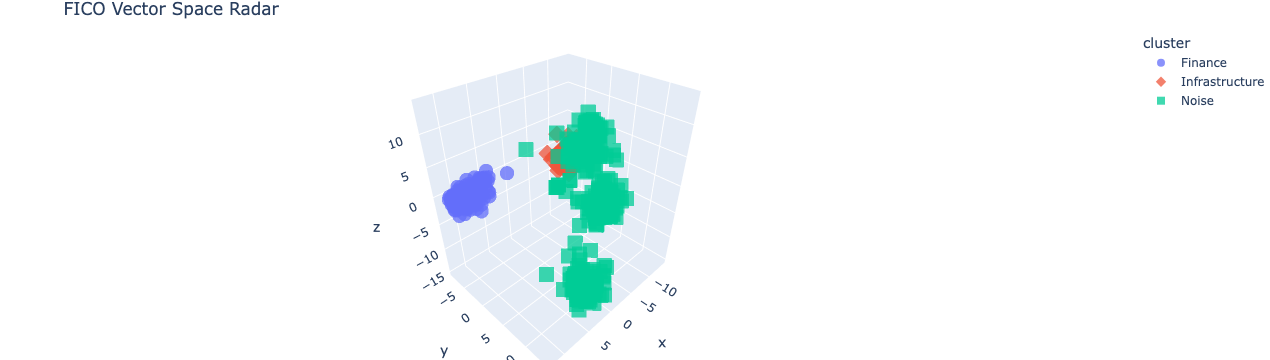

In [17]:
# -- INTERACTIVE RADAR (Real query projection) --


def project_query_to_xyz(query: str):
    q = (query or "").strip()
    if not q:
        return None

    q_emb = embedder.encode([q], normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)

    # Same transform used during corpus generation
    x_scaled = (q_emb - scaler_mean) / (scaler_scale + 1e-12)
    xyz = (x_scaled - pca_mean) @ pca_components.T
    return xyz


def plot_radar(inject_query=None):
    fig = px.scatter_3d(
        df,
        x='x', y='y', z='z',
        color='cluster',
        symbol='cluster',
        opacity=0.75,
        title="FICO Vector Space Radar",
        hover_data={
            "title": True,
            "doc_type": True,
            "tenant_id": True,
            "owner_team": True,
            "redaction_count": True,
        },
    )

    if inject_query:
        xyz = project_query_to_xyz(inject_query)
        if xyz is not None:
            fig.add_trace(
                go.Scatter3d(
                    x=[float(xyz[0])],
                    y=[float(xyz[1])],
                    z=[float(xyz[2])],
                    mode='markers+text',
                    marker=dict(size=10, color='red', symbol='x'),
                    text=[f"QUERY: {inject_query}"],
                    textposition="top center",
                    name='Injected Query',
                )
            )

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
    fig.show()


# Widget Setup
text_input = widgets.Text(
    value='',
    placeholder='Type a query (e.g., "GPU latency impacts APR")',
    description='Query:',
)
button = widgets.Button(description="Inject Query", button_style='danger')


def on_click(b):
    clear_output(wait=True)
    display(ui)
    plot_radar(text_input.value)


button.on_click(on_click)
ui = widgets.VBox([text_input, button])


display(ui)
plot_radar()


## J) RBAC: security filters on top of retrieval

A key point for production systems:

- Vector search retrieves the **most similar** items.
- RBAC/ABAC decides which of those items the user is allowed to see.

In other words: **security is a post-filter** on top‑K retrieval.

In the next cells we’ll run a semantic search, then show:
- which results are **visible**
- which are **blocked**
- and the **reason** (tenant mismatch, role mismatch, restricted tags)


In [18]:
# -- RBAC + REAL VECTOR SEARCH --
# 1) Embed the query
# 2) Retrieve top-K by cosine similarity over saved embeddings
# 3) Apply RBAC filter (tenant/role/restricted tags)

ROLE_LEVEL = {
    "public": 1,
    "analyst": 2,
    "risk_analyst": 2,
    "sre": 3,
    "security": 3,
    "admin": 3,
}

ALL_ROLES = list(ROLE_LEVEL.keys())


def rbac_allow(row, user_role: str, user_tenant: str, clearance_tags: set[str]):
    allowed_roles = row.get("allowed_roles", []) or []
    allowed_tenants = row.get("allowed_tenants", []) or []
    restricted_tags = row.get("restricted_tags", []) or []

    # Admin/security commonly have cross-tenant visibility.
    if user_role in {"admin", "security"}:
        tenant_ok = True
    else:
        tenant_ok = (
            "*" in allowed_tenants
            or (user_tenant in allowed_tenants)
            or (str(row.get("tenant_id", "global")) in ["global", user_tenant])
        )

    if "public" in allowed_roles:
        role_ok = True
    else:
        role_ok = user_role in allowed_roles

    if restricted_tags:
        if user_role in {"admin", "security"}:
            tags_ok = True
        else:
            tags_ok = set(restricted_tags).issubset(clearance_tags)
    else:
        tags_ok = True

    ok = tenant_ok and role_ok and tags_ok

    reason = []
    if not tenant_ok:
        reason.append("tenant")
    if not role_ok:
        reason.append("role")
    if not tags_ok:
        reason.append("restricted_tags")

    return ok, "+".join(reason) if reason else "ok"


def vector_search(query: str, top_k: int = 30):
    q = (query or "").strip()
    if not q:
        return [], None

    q_emb = embedder.encode([q], normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False)[0].astype(np.float32)
    q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-12)

    sims = E_norm @ q_norm

    k = min(int(top_k), len(sims))
    idx = np.argpartition(-sims, k - 1)[:k]
    idx = idx[np.argsort(-sims[idx])]

    results = [(int(i), float(sims[int(i)])) for i in idx]
    return results, q_emb


def rbac_vector_search(query: str, user_role: str, user_tenant: str, clearance_tags: set[str], top_k: int = 30):
    q = (query or "").strip()
    if not q:
        print("❌ Enter a query.")
        return

    print(f"🔎 Semantic search: '{q}' as role='{user_role}' tenant='{user_tenant}' clearance={sorted(list(clearance_tags))}")

    hits, _ = vector_search(q, top_k=top_k)
    if not hits:
        print("❌ No results.")
        return

    visible = []
    blocked_reasons = {}

    for i, score in hits:
        row = df.iloc[i]
        ok, reason = rbac_allow(row, user_role, user_tenant, clearance_tags)
        if ok:
            visible.append((row, score))
        else:
            blocked_reasons[reason] = blocked_reasons.get(reason, 0) + 1

    print("----- Results -----")
    if visible:
        for row, score in visible[:20]:
            title = row.get("title", "(no title)")
            doc_type = row.get("doc_type", "kb")
            tenant_id = row.get("tenant_id", "global")
            tags = row.get("tags", []) or []
            redactions = int(row.get("redaction_count", 0) or 0)
            redact_note = " [has redactable lines]" if redactions > 0 else ""
            print(f"✅ {score:0.3f} | {title} | type={doc_type} tenant={tenant_id} tags={tags}{redact_note}")
    else:
        print("🚫 No visible documents in the top-K results.")

    blocked_count = len(hits) - len(visible)
    if blocked_count > 0:
        print(f"\n🔒 BLOCKED {blocked_count} of top-{len(hits)}")
        for k, v in blocked_reasons.items():
            print(f"  - {k}: {v}")

        print("\nBlocked examples (first 10):")
        shown = 0
        for i, score in hits:
            row = df.iloc[i]
            ok, reason = rbac_allow(row, user_role, user_tenant, clearance_tags)
            if ok:
                continue
            title = row.get("title", "(no title)")
            doc_type = row.get("doc_type", "kb")
            tenant_id = row.get("tenant_id", "global")
            allowed_roles = row.get("allowed_roles", []) or []
            restricted_tags = row.get("restricted_tags", []) or []
            print(f"🚫 {score:0.3f} | {reason} | {title} | type={doc_type} tenant={tenant_id} roles={allowed_roles} restricted={restricted_tags}")
            shown += 1
            if shown >= 10:
                break


# Widgets (optional)
role_dropdown = widgets.Dropdown(options=ALL_ROLES, value="analyst", description="Role:")
tenant_dropdown = widgets.Dropdown(options=["acme", "globex", "initech"], value="acme", description="Tenant:")
clearance_select = widgets.SelectMultiple(
    options=["pii", "secrets", "customer-data", "prod", "credentials"],
    value=(),
    description="Clearance:",
)
topk_slider = widgets.IntSlider(value=30, min=5, max=100, step=5, description="Top-K:")
search_box = widgets.Text(placeholder='Try: "GPU latency impacts APR", "Kubernetes incident runbook"', description='Search:')
btn_rbac = widgets.Button(description="Run Secure Semantic Search")


def on_rbac_click(b):
    clear_output(wait=True)
    display(ui_rbac)
    rbac_vector_search(
        search_box.value,
        role_dropdown.value,
        tenant_dropdown.value,
        set(clearance_select.value),
        top_k=int(topk_slider.value),
    )


btn_rbac.on_click(on_rbac_click)
ui_rbac = widgets.VBox([role_dropdown, tenant_dropdown, clearance_select, topk_slider, search_box, btn_rbac])

display(ui_rbac)

In [12]:
# --- RBAC Impact Metrics + Result Inspector ---
# Works with the real semantic search state loaded earlier (df, E_norm, embedder, etc.).

LAST_RUN = {}


def rbac_breakdown(row, user_role: str, user_tenant: str, clearance_tags: set[str]):
    allowed_roles = row.get("allowed_roles", []) or []
    allowed_tenants = row.get("allowed_tenants", []) or []
    restricted_tags = row.get("restricted_tags", []) or []

    if user_role in {"admin", "security"}:
        tenant_ok = True
    else:
        tenant_ok = (
            "*" in allowed_tenants
            or (user_tenant in allowed_tenants)
            or (str(row.get("tenant_id", "global")) in ["global", user_tenant])
        )

    if "public" in allowed_roles:
        role_ok = True
    else:
        role_ok = user_role in allowed_roles

    if restricted_tags:
        if user_role in {"admin", "security"}:
            tags_ok = True
        else:
            tags_ok = set(restricted_tags).issubset(clearance_tags)
    else:
        tags_ok = True

    return {
        "tenant_ok": bool(tenant_ok),
        "role_ok": bool(role_ok),
        "tags_ok": bool(tags_ok),
        "allowed_roles": allowed_roles,
        "allowed_tenants": allowed_tenants,
        "restricted_tags": restricted_tags,
        "user_role": user_role,
        "user_tenant": user_tenant,
        "user_clearance": sorted(list(clearance_tags)),
    }


def apply_rbac(hits, user_role: str, user_tenant: str, clearance_tags: set[str]):
    visible = []
    blocked = []
    reason_counts = {}

    for i, score in hits:
        row = df.iloc[int(i)]
        ok, reason = rbac_allow(row, user_role, user_tenant, clearance_tags)
        if ok:
            visible.append((int(i), float(score)))
        else:
            blocked.append((int(i), float(score), str(reason)))
            reason_counts[str(reason)] = reason_counts.get(str(reason), 0) + 1

    return visible, blocked, reason_counts


def run_and_store(query: str, user_role: str, user_tenant: str, clearance_tags: set[str], top_k: int = 30):
    hits, _ = vector_search(query, top_k=top_k)
    visible, blocked, reasons = apply_rbac(hits, user_role, user_tenant, clearance_tags)

    LAST_RUN.clear()
    LAST_RUN.update(
        {
            "query": query,
            "top_k": int(top_k),
            "user_role": user_role,
            "user_tenant": user_tenant,
            "clearance": sorted(list(clearance_tags)),
            "hits": hits,
            "visible": visible,
            "blocked": blocked,
            "blocked_reasons": reasons,
        }
    )
    return LAST_RUN


def rbac_impact_metrics(query: str, tenant: str, clearance_tags: set[str], top_k: int = 30):
    q = (query or "").strip()
    if not q:
        print("❌ Enter a query.")
        return

    roles = ["analyst", "security"]
    reports = {}

    print(f"\n=== RBAC impact metrics for query: {q!r} (top_k={int(top_k)}) ===")

    for role in roles:
        hits, _ = vector_search(q, top_k=top_k)
        visible, blocked, reasons = apply_rbac(hits, role, tenant, clearance_tags)

        reports[role] = {
            "hits": hits,
            "visible": visible,
            "blocked": blocked,
            "reasons": reasons,
        }

        print(f"\nRole={role} tenant={tenant} clearance={sorted(list(clearance_tags))}")
        print(f"- topK before RBAC: {len(hits)}")
        print(f"- topK after RBAC:  {len(visible)}")
        print(f"- blocked:          {len(blocked)}")
        if reasons:
            print("- blocked by reason:")
            for k, v in sorted(reasons.items(), key=lambda kv: (-kv[1], kv[0])):
                print(f"  - {k}: {v}")
        else:
            print("- blocked by reason: (none)")

    # security vs analyst comparison
    sec_ids = {i for i, _ in reports["security"]["visible"]}
    ana_ids = {i for i, _ in reports["analyst"]["visible"]}
    print("\n=== security vs analyst comparison (visible set overlap) ===")
    print(f"- security visible: {len(sec_ids)}")
    print(f"- analyst visible:  {len(ana_ids)}")
    print(f"- overlap:          {len(sec_ids & ana_ids)}")
    print(f"- security-only:    {len(sec_ids - ana_ids)}")


def inspect_idx(i: int, user_role: str, user_tenant: str, clearance_tags: set[str], score: float | None = None):
    row = df.iloc[int(i)]

    ok, reason = rbac_allow(row, user_role, user_tenant, clearance_tags)
    breakdown = rbac_breakdown(row, user_role, user_tenant, clearance_tags)

    print("\n=== Result inspector ===")
    if score is not None:
        print(f"score: {float(score):0.4f}")
    print(f"doc_id: {row.get('doc_id')}")
    print(f"pair_id: {row.get('pair_id')}")
    print(f"cluster: {row.get('cluster')}")
    print(f"tenant_id: {row.get('tenant_id')}")
    print(f"doc_type: {row.get('doc_type')}")
    print(f"owner_team: {row.get('owner_team')}")
    print(f"tags: {row.get('tags')}")
    print(f"restricted_tags: {row.get('restricted_tags')}")
    print(f"allowed_roles: {row.get('allowed_roles')}")
    print(f"allowed_tenants: {row.get('allowed_tenants')}")
    print(f"redaction_count: {row.get('redaction_count')}")

    print("\n--- RBAC decision ---")
    print(f"visible: {ok} (reason={reason})")
    print(f"tenant_ok={breakdown['tenant_ok']} role_ok={breakdown['role_ok']} tags_ok={breakdown['tags_ok']}")

    print("\n--- TITLE ---")
    print(row.get("title", ""))

    print("\n--- BODY (full) ---")
    print(row.get("body", ""))

    print("\n--- BODY (redacted) ---")
    print(row.get("body_redacted", ""))


def inspect_last(rank: int = 0, which: str = "visible"):
    if not LAST_RUN:
        print("❌ No LAST_RUN yet. Run a search first (rbac_vector_search or run_and_store).")
        return

    if which == "visible":
        items = LAST_RUN.get("visible", [])
        if rank >= len(items):
            print(f"❌ rank {rank} out of range for visible (len={len(items)})")
            return
        i, score = items[rank]
    else:
        items = LAST_RUN.get("hits", [])
        if rank >= len(items):
            print(f"❌ rank {rank} out of range for hits (len={len(items)})")
            return
        i, score = items[rank]

    inspect_idx(
        i,
        user_role=LAST_RUN.get("user_role", "analyst"),
        user_tenant=LAST_RUN.get("user_tenant", "acme"),
        clearance_tags=set(LAST_RUN.get("clearance", [])),
        score=score,
    )


# Optional widget UI for metrics + inspector
metrics_btn = widgets.Button(description="RBAC impact metrics (security vs analyst)")
inspect_btn = widgets.Button(description="Inspect selected")
run_search_btn = widgets.Button(description="Run search (populate pick list)")

metrics_query = widgets.Text(value="Kubernetes incident runbook", description="Query:")
metrics_role = widgets.Dropdown(options=["analyst", "sre", "security", "admin"], value="security", description="Role:")
metrics_tenant = widgets.Dropdown(options=["acme", "globex", "initech"], value="acme", description="Tenant:")
metrics_clearance = widgets.SelectMultiple(
    options=["pii", "secrets", "customer-data", "prod", "credentials"],
    value=(),
    description="Clearance:",
)
metrics_topk = widgets.IntSlider(value=30, min=5, max=100, step=5, description="Top-K:")

# Pick list is populated by the button above (self-contained) or by other RBAC search cells.
inspect_dropdown = widgets.Dropdown(options=[("(run a search first)", -1)], description="Pick:")


def refresh_inspect_dropdown():
    if not LAST_RUN:
        inspect_dropdown.options = [("(run a search first)", -1)]
        return

    opts = []
    # show visible results first
    for rank, (i, score) in enumerate(LAST_RUN.get("visible", [])[:30]):
        row = df.iloc[int(i)]
        title = str(row.get("title", "(no title)"))
        opts.append((f"v{rank} {score:0.3f} | {title[:80]}", int(i)))

    if not opts:
        # fall back to raw hits if nothing visible
        for rank, (i, score) in enumerate(LAST_RUN.get("hits", [])[:30]):
            row = df.iloc[int(i)]
            title = str(row.get("title", "(no title)"))
            opts.append((f"h{rank} {score:0.3f} | {title[:80]}", int(i)))

    inspect_dropdown.options = opts


# Output panel so button actions always show results (and don't get wiped by clear_output)
out_metrics = widgets.Output()


def on_metrics_click(b):
    with out_metrics:
        clear_output(wait=True)
        rbac_impact_metrics(metrics_query.value, metrics_tenant.value, set(metrics_clearance.value), top_k=int(metrics_topk.value))

        # Keep the inspector pick list in sync with the same query/settings.
        run_and_store(
            metrics_query.value,
            metrics_role.value,
            metrics_tenant.value,
            set(metrics_clearance.value),
            top_k=int(metrics_topk.value),
        )
        refresh_inspect_dropdown()


def on_run_search_click(b):
    with out_metrics:
        clear_output(wait=True)
        run_and_store(
            metrics_query.value,
            metrics_role.value,
            metrics_tenant.value,
            set(metrics_clearance.value),
            top_k=int(metrics_topk.value),
        )
        refresh_inspect_dropdown()

        v = len(LAST_RUN.get("visible", []) or [])
        blk = len(LAST_RUN.get("blocked", []) or [])
        print(f"Populated pick list (visible={v}, blocked={blk})")


def on_inspect_click(b):
    with out_metrics:
        clear_output(wait=True)
        i = int(inspect_dropdown.value)
        if i < 0:
            print("❌ Run a search first to populate selectable results.")
            return
        # Use current widget role/tenant if available from LAST_RUN, else defaults
        role = LAST_RUN.get("user_role", metrics_role.value)
        tenant = LAST_RUN.get("user_tenant", metrics_tenant.value)
        clearance = set(LAST_RUN.get("clearance", list(metrics_clearance.value)))
        inspect_idx(i, role, tenant, clearance)


metrics_btn.on_click(on_metrics_click)
run_search_btn.on_click(on_run_search_click)
inspect_btn.on_click(on_inspect_click)

ui_metrics = widgets.VBox([
    widgets.HTML("<b>RBAC impact metrics + result inspector</b>"),
    metrics_query,
    widgets.HBox([metrics_role, metrics_tenant, metrics_topk]),
    metrics_clearance,
    widgets.HBox([metrics_btn, run_search_btn, inspect_btn]),
    inspect_dropdown,
    out_metrics,
])

# Call this manually after running a search, or just re-run this cell.
refresh_inspect_dropdown()

display(ui_metrics)

# Direct-call examples (works even if widgets are broken):
# rbac_impact_metrics("GPU latency impacts APR", tenant="acme", clearance_tags=set(), top_k=30)
# run_and_store("Kubernetes incident runbook", "security", "acme", set(), top_k=30); inspect_last(0)


In [11]:
# ---- NO-WIDGET FALLBACK ----
# If ipywidgets don't render/click in your environment, run semantic search directly:

print("\n=== Non-widget demo (direct calls) ===")

# Security (cross-tenant) should see the most.
rbac_vector_search("Kubernetes incident runbook", "security", "acme", set(), top_k=30)

print("\n---")
# Analyst should see fewer (role-gated) and may hit restricted_tags blocks.
rbac_vector_search("GPU latency impacts APR", "analyst", "acme", set(), top_k=30)

print("\n---")
# Analyst with secrets clearance.
rbac_vector_search("SECRET", "analyst", "acme", {"secrets"}, top_k=30)




=== Non-widget demo (direct calls) ===
🔎 Semantic search: 'Kubernetes incident runbook' as role='security' tenant='acme' clearance=[]
----- Results -----
✅ 0.682 | ["...", "..."] } assistant { "title": "Kubernetes Incident Response for Crash Loops", "body": "In the event of a Kubernetes cluster crash lo | type=runbook tenant=globex tags=['docker', 'driver', 'kubernetes', 'latency', 'observability']
✅ 0.565 | ... | type=runbook tenant=initech tags=['...', 'docker', 'driver', 'firewall', 'kubernetes', 'latency']
✅ 0.543 | ... | type=runbook tenant=initech tags=['...', 'docker', 'firewall', 'gpu', 'kubernetes', 'observability']
✅ 0.530 | ... | type=runbook tenant=acme tags=['...', 'docker', 'driver', 'gpu', 'kubernetes', 'observability']
✅ 0.501 | "title": "...", "body": "...", "tags": ["...", "..."] } assistant { "title": "Driver/CUDA Compatibility and Container Deployment Issues", "b | type=runbook tenant=acme tags=['docker', 'driver', 'firewall', 'gpu', 'kubernetes']
✅ 0.483 | ... | t